In [ ]:
# Run if dependencies are not installed
# !pip3 install -r torch datasets av

In [ ]:
!pip3 install matplotlib

In [1]:
%matplotlib inline

import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from egowalk_dataset.datasets.gnm.gnm_indexing import index_gnm_text
from egowalk_dataset.datasets.gnm.cutters import (SpikesCutter,
                                                  StuckCutter,
                                                  BackwardCutter)
from egowalk_dataset.datasets.base.base_dataset import EgoWalkBaseDataset
from egowalk_dataset.datasets.gnm.gnm_dataset import (GNMDataset, 
                                                      DefaultGNMDataset, 
                                                      GNMRGBFeature, 
                                                      GNMDepthFeature, 
                                                      GNMWaypointFeature, 
                                                      GNMCaptionFeature, 
                                                      GNMBBoxFeature)
from egowalk_dataset.misc.constants import HF_EGOWALK_HOME



/home/timur_akht/.miniconda3/envs/egowalk_ds_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the dataset if not downloaded
REPO_ID = "EgoWalk/trajectories"

# We specify only 2 trajectories to avoid downloading too much data
_ = EgoWalkBaseDataset(repo_id=REPO_ID, root=None,
                       trajectories=["2024_08_15__19_55_49",
                                      "2024_12_10__20_17_45"])

DATASET_ROOT = HF_EGOWALK_HOME / REPO_ID

In [3]:
gnm_index = index_gnm_text(context_length=5,
                           action_length=5,
                           root=DATASET_ROOT,
                           n_workers=12,
                           use_tqdm=True,
                           caption_type="normal",
                           window_step=2,
                           n_window_steps=4)





100%|██████████| 239/239 [00:14<00:00, 16.41it/s]


In [4]:
ds = GNMDataset(index=gnm_index,
                 root=DATASET_ROOT,
                 features=[GNMRGBFeature(name="obs",
                                        field="obs"),
                            GNMCaptionFeature(name="goal"),
                            GNMBBoxFeature(name="goal_bbox"),
                            GNMWaypointFeature(name="action",
                                               angle_format="sincos")])

In [5]:
print(len(ds))

61783


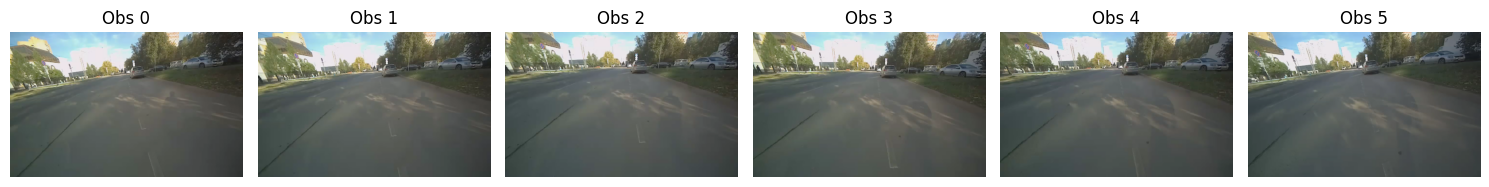

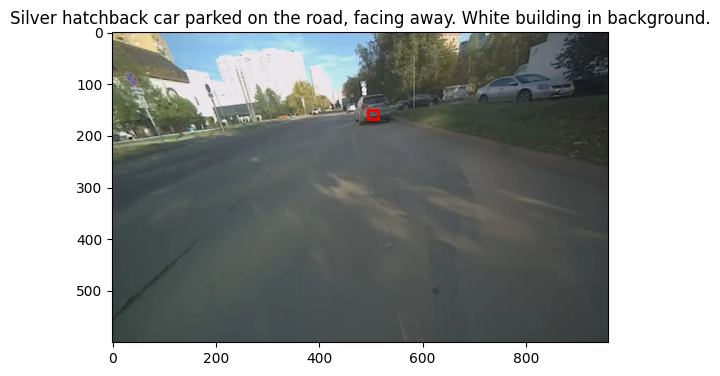

/tmp/ipykernel_4018074/4237200019.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dx = np.cos(angle) * 0.01  # Scale arrow length
/tmp/ipykernel_4018074/4237200019.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dy = np.sin(angle) * 0.01


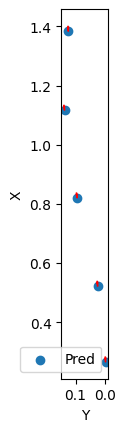

In [8]:
idx = np.random.randint(0, len(ds))

item = ds[idx]
num_obs = len(item["obs"])
fig, axes = plt.subplots(1, num_obs, figsize=(15, 5))
for i in range(num_obs):
    axes[i].imshow(item["obs"][i])
    axes[i].set_title(f"Obs {i}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

plt.imshow(ds[idx]["obs"][-1])
bbox = ds[idx]["goal_bbox"]
plt.title(ds[idx]["goal"])

# Draw bounding box rectangle
x, y, w, h = bbox
rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
plt.gca().add_patch(rect)

plt.show()

traj = ds[idx]["action"]
plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
ax.invert_xaxis()
ax.scatter(x=traj[:, 1], y=traj[:, 0], label="Pred")

# Add arrows to show direction based on the angle (traj[:, 2])
for i in range(len(traj)):
    angle = traj[i, 2]
    # Calculate arrow direction components
    dx = np.cos(angle) * 0.01  # Scale arrow length
    dy = np.sin(angle) * 0.01
    # Draw arrow at each trajectory point
    ax.arrow(traj[i, 1], traj[i, 0], dy, dx, 
             head_width=0.005, head_length=0.008, fc='red', ec='red')

ax.set_xlabel("Y")
ax.set_ylabel("X")
plt.legend()
plt.show()
